In [1]:
# load libraries 
import pandas as pd
import numpy as np
import re
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from __future__ import division
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc , roc_curve, accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [2]:
#reading the training and test data 
train_data = pd.read_csv("C:/Users/lab/Desktop/Maryam/My_CV/applied_Jobs/Scotia Bank/GiveMeSomeCredit/cs-training.csv")
test_data = pd.read_csv("C:/Users/lab/Desktop/Maryam/My_CV/applied_Jobs/Scotia Bank/GiveMeSomeCredit/cs-test.csv")

In [3]:
#training dataset analysis
train_data.head()
train_data.shape
train_data.describe()
train_data.info()
train_data.isnull().sum()
# we an see that min of age is zero, and also monthlyincome and 
# numberofdependancies have some null values, I will sort them out in the next steps.
# SeriousDlqin2yrs is what we predict

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
#test dataset analysis
test_data.head()
test_data.shape
test_data.describe()
test_data.info()
test_data.isnull().sum()

# again we an see that the monthlyincome and 
# numberofdependancies have some null values
# SeriousDlqin2yrs is completely empty

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
Unnamed: 0                              101503 non-null int64
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(7)
memory usage: 9.3 MB


Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

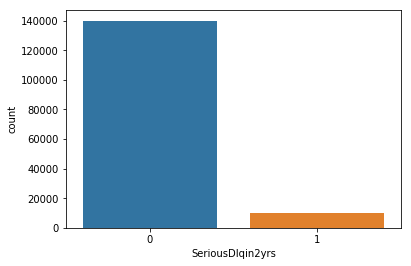

In [5]:
#Let's have a look at SeriousDlqin2yrs (this isi whta we predict)
ax = sns.countplot(x = train_data.SeriousDlqin2yrs)

# as we can see we are facing an imbalanced dataset
# in terms of positive and negative samples
# I over and under samples inorder to have balanced data

In [6]:
# statiscally detecting outliers

def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        # thisi s smilar to Z score
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train_data,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [7]:
# number of the data we nne d to eliminate
len(Outliers_to_drop)

3527

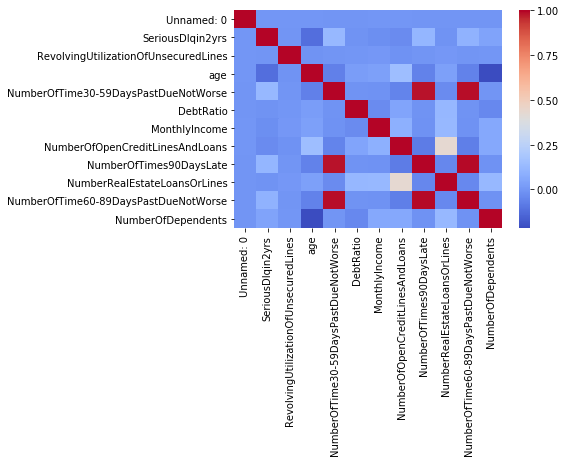

In [8]:
# correlation matrix 
g = sns.heatmap(train_data.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

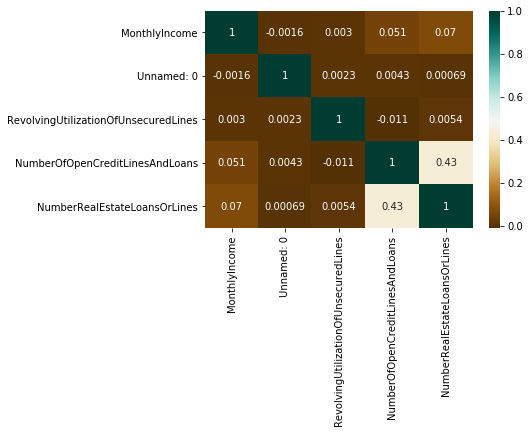

In [9]:
dataset =  pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)
dataset.MonthlyIncome.isnull().sum()

g = sns.heatmap(dataset[["MonthlyIncome","Unnamed: 0",
                         "RevolvingUtilizationOfUnsecuredLines",
                         "NumberOfOpenCreditLinesAndLoans",
                         "NumberRealEstateLoansOrLines"]].corr(),cmap="BrBG",annot=True)

# g = sns.heatmap(dataset[["MonthlyIncome","age","DebtRatio","NumberOfDependents",
#                          "SeriousDlqin2yrs"]].corr(),cmap="BrBG",annot=True)
#g = sns.heatmap(dataset[["MonthlyIncome","NumberOfTime30-59DaysPastDueNotWorse",
                         #"NumberOfTime60-89DaysPastDueNotWorse",
                         #"NumberOfTimes90DaysLate"]].corr(),cmap="BrBG",annot=True)
        
        
# uncomment to see the other charts

# We can see that MonthlyIncome has no strong correlation with any other variable
#so we cannot accurately estimate the NaN values. 
#Thus, we will fill the NaN with the median value        

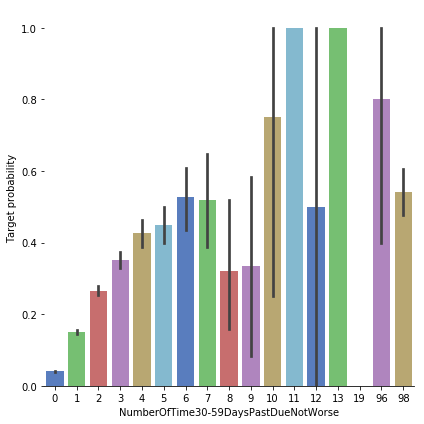

In [10]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="NumberOfTime30-59DaysPastDueNotWorse",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [11]:
for i in range(len(dataset)):
    if dataset['NumberOfTime30-59DaysPastDueNotWorse'][i] >= 6:
        dataset['NumberOfTime30-59DaysPastDueNotWorse'][i] = 6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


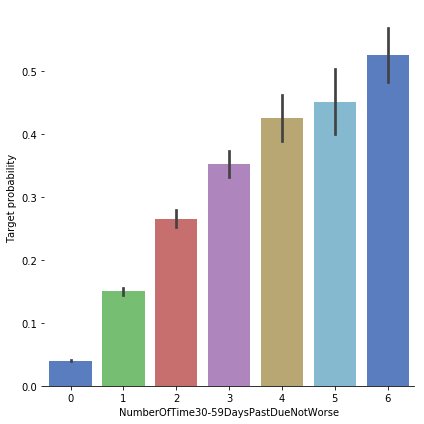

In [12]:
g  = sns.factorplot(x="NumberOfTime30-59DaysPastDueNotWorse",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

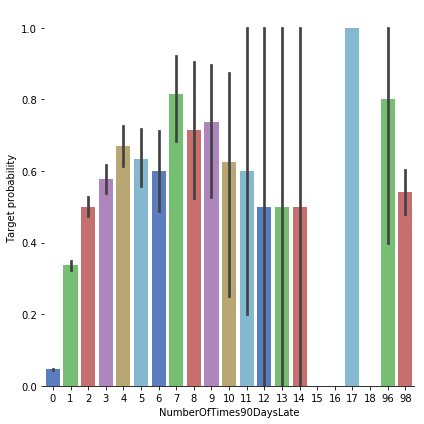

In [13]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="NumberOfTimes90DaysLate",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [14]:
for i in range(len(dataset)):
    if dataset.NumberOfTimes90DaysLate[i] >= 5:
        dataset.NumberOfTimes90DaysLate[i] = 5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


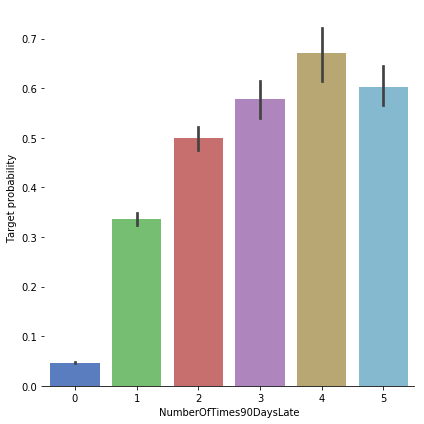

In [15]:
g  = sns.factorplot(x="NumberOfTimes90DaysLate",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

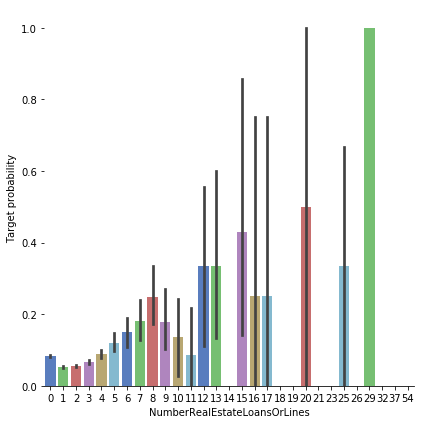

In [16]:
g  = sns.factorplot(x="NumberRealEstateLoansOrLines",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [17]:
for i in range(len(dataset)):
    if dataset.NumberRealEstateLoansOrLines[i] >= 6:
        dataset.NumberRealEstateLoansOrLines[i] = 6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


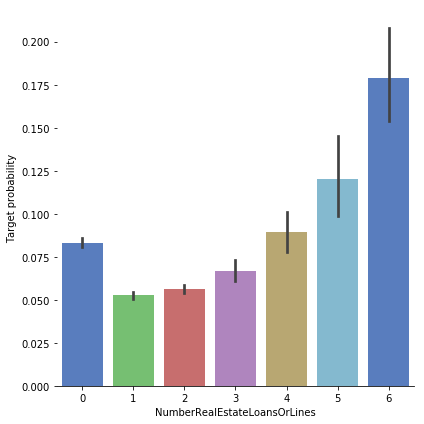

In [18]:
g  = sns.factorplot(x="NumberRealEstateLoansOrLines",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

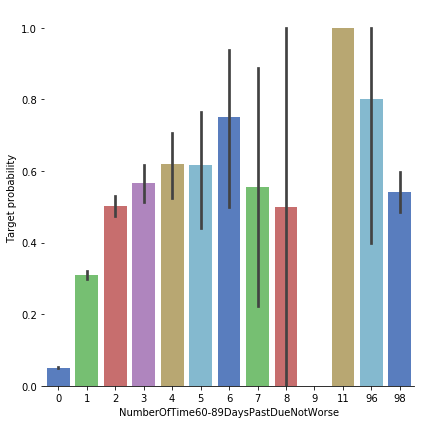

In [19]:
g  = sns.factorplot(x="NumberOfTime60-89DaysPastDueNotWorse",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [20]:
for i in range(len(dataset)):
    if dataset['NumberOfTime60-89DaysPastDueNotWorse'][i] >= 3:
        dataset['NumberOfTime60-89DaysPastDueNotWorse'][i] = 3

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


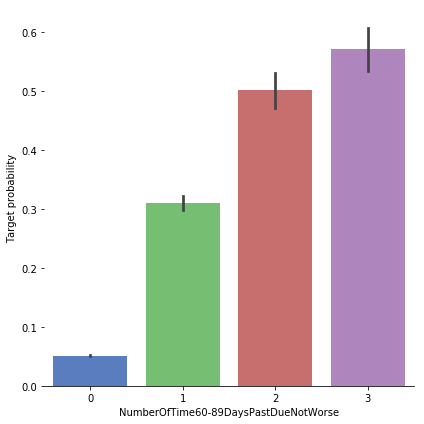

In [21]:
g  = sns.factorplot(x="NumberOfTime60-89DaysPastDueNotWorse",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

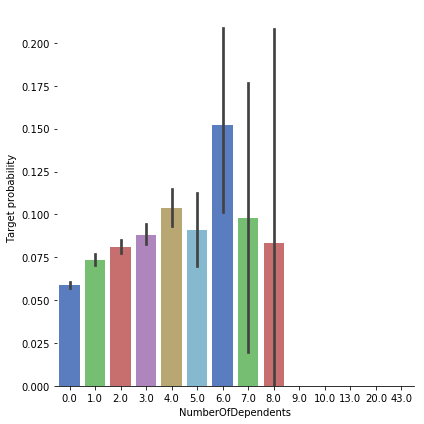

In [22]:
# Explore Dependancies feature quantiles vs Target
g  = sns.factorplot(x="NumberOfDependents",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [23]:
for i in range(len(dataset)):
    if dataset.NumberOfDependents[i] >= 4:
        dataset.NumberOfDependents[i] = 4

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


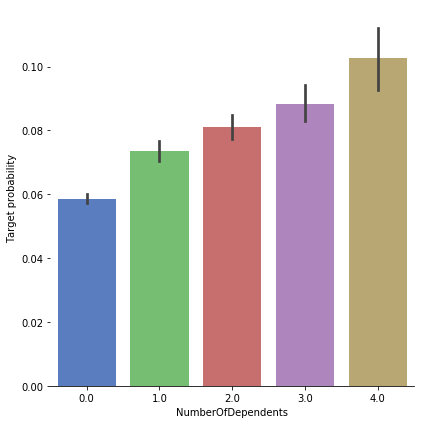

In [24]:
# Explore Dependancies feature quantiles vs Target
g  = sns.factorplot(x="NumberOfDependents",y="SeriousDlqin2yrs",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [25]:
dataset.MonthlyIncome.median()
#Fill Embarked nan values of dataset set with the most frequent value
dataset.MonthlyIncome = dataset.MonthlyIncome.fillna(dataset.MonthlyIncome.median())
dataset.NumberOfDependents = dataset.NumberOfDependents.fillna(dataset.NumberOfDependents.median())
dataset = dataset.drop("Unnamed: 0", axis=1)

In [27]:
# no null anymore
dataset.isnull().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

In [28]:
len_train = len(train_data)
train = dataset[:len_train]
test = dataset[len_train:]

In [29]:
y = train["SeriousDlqin2yrs"]
X = train.drop( "SeriousDlqin2yrs",axis = 1)
# converting to numpy 
y= y.values
X = X.values

In [30]:
def over_under_sampling (Xtrain,ytrain,Xtest,ytest):

    #print(Counter(ytrain))
    #print(Counter(ytest))
    # train oversampling
    over = RandomOverSampler(sampling_strategy=0.6)
    # fit and apply the transform
    Xtrain_over, ytrain_over = over.fit_resample(Xtrain, ytrain)
    # define undersampling strategy
    under = RandomUnderSampler(sampling_strategy='majority')
    # fit and apply the transform
    Xtrain, ytrain = under.fit_resample(Xtrain_over,ytrain_over)
    #print(Counter(ytrain))
    
    
    # test oversampling
    over = RandomOverSampler(sampling_strategy=0.6)
    # fit and apply the transform
    Xtest_over, ytest_over = over.fit_resample(Xtest, ytest)
    # define undersampling strategy
    under = RandomUnderSampler(sampling_strategy='majority')
    # fit and apply the transform
    Xtest, ytest = under.fit_resample(Xtest_over,ytest_over)
    # summarize class distribution
    #print(Counter(ytest))
    
    return Xtrain , ytrain , Xtest, ytest
    

i: 0
i: 1
i: 2
i: 3
i: 4


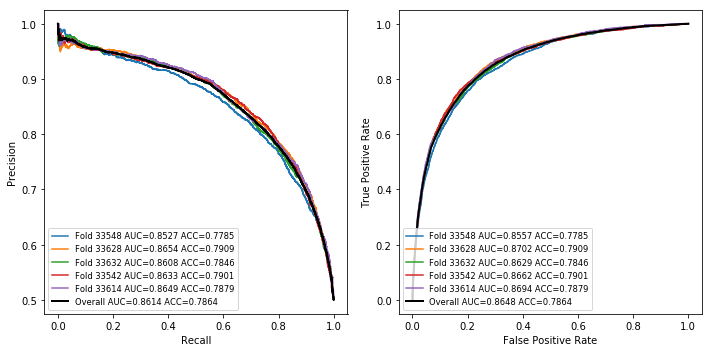

In [40]:
# Using the Cross validation 

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
# model type
#model = RandomForestClassifier(n_estimators= 300, random_state = 20)


# model = SVC(C=1.0, kernel='linear', degree=3, coef0=0.0, shrinking=True,
#            probability=True,tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1,
#            decision_function_shape='ovo', random_state=None)

#model = SVC(kernel='linear')
model = sklearn.ensemble.BaggingRegressor(base_estimator=sklearn.ensemble.GradientBoostingRegressor(max_depth=4,
                                            n_estimators=130),
                                          n_estimators=30)

# creating the plot of PR curve and ROC curve with the model above
# plotting pr and roc curve
f, axes = plt.subplots(1, 2, figsize=(10, 5))

# need this initialization to get the PR curve in cross validation 
y_real = []
y_proba = []
y_pred=[]

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    
    print('i:',i)
    
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
        
    # re-sampling the data to get more balanced dataset    
    Xtrain , ytrain , Xtest, ytest = over_under_sampling (Xtrain,ytrain, Xtest, ytest)
    
    # fitting the model 
    model.fit(Xtrain, ytrain)
    # predicitng the output probability
    #pred_proba = model.predict_proba(Xtest)
    pred_proba = model.predict(Xtest)
    
    # for the sake of ploting the PR Curve and ROC Curve
    # getting the Precision and Recall
    precision, recall, _ = precision_recall_curve(ytest, pred_proba)#[:,1])
    # getting False positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(ytest, pred_proba)#[:, 1])
    
    # accuracy
    yhat=[]
    out_data = model.predict(Xtest)
    for i in range(len(out_data)):
        if out_data[i]<=0.5:
            yhat.append(0)
        else:
            yhat.append(1)
        
    acc = accuracy_score(ytest, yhat)
        
    # pr curve
    lab = 'Fold %d AUC=%.4f ACC=%.4f' % (i+1, auc(recall, precision),acc)
    axes[0].step(recall, precision, label=lab)

    # roc curve
    lab = 'Fold %d AUC=%.4f ACC=%.4f' % (i+1, auc(fpr, tpr), acc)
    axes[1].step(fpr, tpr, label=lab)

    # getting all values of test and probability of cross validation
    y_real.append(ytest)
    y_proba.append(pred_proba)#[:,1])
    y_pred.append(yhat)

    
    
    
# final pr and roc curve

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
y_pred = np.concatenate(y_pred)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
fpr, tpr, thresholds = roc_curve(y_real,  y_proba)
acc = accuracy_score(y_real, y_pred)

# pr curve
lab = 'Overall AUC=%.4f ACC=%.4f' % (auc(recall, precision),acc)
axes[0].step(recall, precision, label=lab, lw=2, color='black')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend(loc='lower left', fontsize='small')

#roc curve
lab = 'Overall AUC=%.4f ACC=%.4f' % (auc(fpr, tpr),acc)
axes[1].step(fpr, tpr, label=lab, lw=2, color='black')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower left', fontsize='small')

f.tight_layout()
f.savefig('C:/Users/lab/Desktop/Maryam/My_CV/applied_Jobs/Scotia Bank/GiveMeSomeCredit/Pr_ROC_curve.png')